In [1]:
import crocoddyl

In [2]:
import matplotlib.pyplot as plt
import numpy as np


def plotUnicycle(x):
    sc, delta = .1, .1
    a, b, th = np.asscalar(x[0]), np.asscalar(x[1]), np.asscalar(x[2])
    c, s = np.cos(th), np.sin(th)
    refs = [
        plt.arrow(a - sc / 2 * c - delta * s, b - sc / 2 * s + delta * c, c * sc, s * sc, head_width=.05),
        plt.arrow(a - sc / 2 * c + delta * s, b - sc / 2 * s - delta * c, c * sc, s * sc, head_width=.05)
    ]
    return refs


def plotUnicycleSolution(xs, figIndex=1, show=True):
    plt.figure(figIndex, figsize=(6.4, 6.4))
    for x in xs:
        plotUnicycle(x)
    plt.axis([-2, 2., -2., 2.])
    if show:
        plt.show()

In [3]:
import numpy as np
import matplotlib.pylab as plt

x = np.random.rand(3)
u = np.random.rand(2)

# Unicycle dynamical model
v, w = u
c, s = np.cos(x[2]), np.sin(x[2])
dt = 1e-2
dx = np.array([v * c, v * s, w])
xnext = x + dx * dt

# # Cost function: driving to origin (state) and reducing speed (control)
# stateWeight = 1
# ctrlWeight = 1
# costResiduals = np.concatenate([stateWeight * x, ctrlWeight * u])
# cost = .5 * sum(costResiduals ** 2)


In [4]:
import crocoddyl
model = crocoddyl.ActionModelUnicycle()
data = model.createData()

In [5]:
model.costWeights = np.matrix([
    2,   # state weight
    1  # control weight
]).T

In [6]:
x0 = np.matrix([-1., -1., 1.]).T  # x, y, theta
T = 40
problem = crocoddyl.ShootingProblem(x0, [model] * T, model)

In [7]:
us = [np.matrix([0.5, 1.]).T for _ in range(T)]
xs = problem.rollout(us)

<ipython-input-2-0e58104c45a1>:7: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a, b, th = np.asscalar(x[0]), np.asscalar(x[1]), np.asscalar(x[2])


(-2.0, 2.0, -2.0, 2.0)

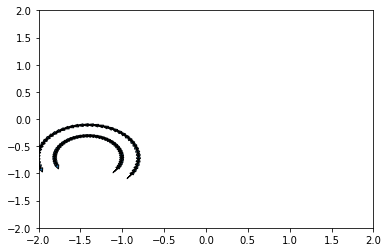

In [8]:
%matplotlib inline
# from unicycle_utils import plotUnicycle
for x in xs: 
    plotUnicycle(x)
plt.axis([-2, 2., -2., 2.])

In [9]:
ddp = crocoddyl.SolverDDP(problem)
done = ddp.solve()
assert done

<ipython-input-2-0e58104c45a1>:7: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a, b, th = np.asscalar(x[0]), np.asscalar(x[1]), np.asscalar(x[2])


(-2.0, 2.0, -2.0, 2.0)

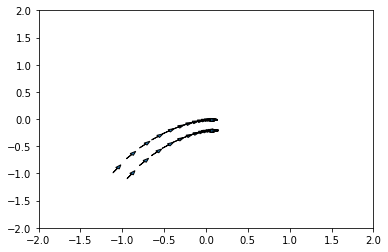

In [10]:
plt.clf()
for x in ddp.xs: 
    plotUnicycle(x)
plt.axis([-2, 2, -2, 2])

In [11]:
print(ddp.xs[-1])

[ 0.0012328  -0.11767217  0.00078096]


In [13]:
import crocoddyl
import pinocchio
import numpy as np
import example_robot_data
from crocoddyl.utils.biped import SimpleBipedGaitProblem

# Creating the lower-body part of Talos
talos_legs = example_robot_data.load('talos_legs')

# Setting up the 3d walking problem
rightFoot = 'right_sole_link'
leftFoot = 'left_sole_link'
gait = SimpleBipedGaitProblem(talos_legs.model, rightFoot, leftFoot)


# Create the initial state
q0 = talos_legs.q0.copy()
v0 = pinocchio.utils.zero(talos_legs.model.nv)
x0 = np.concatenate([q0, v0])


# Creating the walking problem
stepLength = 0.6 # meters
stepHeight = 0.1 # meters
timeStep = 0.0375 # seconds
stepKnots = 20
supportKnots = 10
problem = gait.createWalkingProblem(x0, stepLength, stepHeight, timeStep, stepKnots, supportKnots)


# Solving the 3d walking problem using Feasibility-prone DDP
ddp = crocoddyl.SolverFDDP(problem)

# Using the meshcat displayer, you could enable gepetto viewer for nicer view
# display = crocoddyl.GepettoDisplay(talos_legs, 4, 4, frameNames=[rightFoot, leftFoot])
display = crocoddyl.MeshcatDisplay(talos_legs, 4, 4, False)
ddp.setCallbacks([crocoddyl.CallbackLogger(),
                  crocoddyl.CallbackVerbose(),
                  crocoddyl.CallbackDisplay(display)])

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [14]:
display.robot.viewer.jupyter_cell()

In [16]:
# Solve the optimal control problem
ddp.th_stop = 1e-9
init_xs = [x0] * (problem.T + 1)
init_us = []
maxiter = 1000
regInit = 0.1
ddp.solve(init_xs, init_us, maxiter, False, regInit)

True

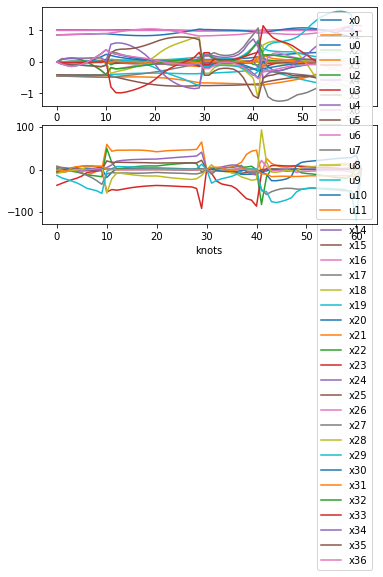

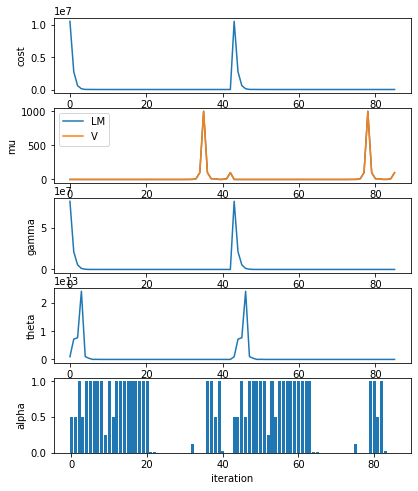

In [17]:
# Plotting the solution and the DDP convergence
log = ddp.getCallbacks()[0]
crocoddyl.plotOCSolution(log.xs, log.us)
crocoddyl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps)

In [26]:
# Visualization of the DDP solution in meshcat
display.rate = -1
display.freq = 1
display.displayFromSolver(ddp)

In [27]:
display.robot.viewer.jupyter_cell()